- [Data](#Data)
- [Model](#Model)

# Dependencies

In [1]:
#visualization
import matplotlib.pyplot as plt

#math tools
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

#machine learning
import torch
from sklearn import metrics
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

#utils
from time import time
from os.path import join
from os import listdir


cuda


# Utils

In [2]:
measure2index={"x-coordinate":0,"y-coordinate":1,"timestamp":2, "button_status":3,"pressure":4, "tilt":5,"elevation":6}
index2measure=list(measure2index.keys())

task2index={"spiral":0,"l":1,"le":2 ,"les":3,"lektorka" :4,"porovnat":5,"nepopadnout":6, "tram":7}
index2task=list(task2index.keys())

In [3]:
index2measure

['x-coordinate',
 'y-coordinate',
 'timestamp',
 'button_status',
 'pressure',
 'tilt',
 'elevation']

In [4]:
index2task

['spiral', 'l', 'le', 'les', 'lektorka', 'porovnat', 'nepopadnout', 'tram']

In [5]:
def timeSince(since):
    now = time()
    s = now - since
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Data
## Loading

In [6]:
data_path=join("..","PaHaW","PaHaW_public")#/00026/00026__1_1.svc"
folder_path=listdir(data_path)
folder_path.sort()

In [7]:
meta_path=join("..","PaHaW","corpus_PaHaW.csv")
meta_data=[]
with open(meta_path) as file:
    for line in file.readlines():
        meta_data.append(line.split(";"))
meta_data.pop(0)
meta_data=np.asarray(meta_data)
labels=[1 if i =="ON" else 0 for i in meta_data[:,4]]


In [8]:
#a priori unnecessary for binary classif
target=[[0,1] if i ==1 else [1,0] for i in labels]

In [9]:
task_path=listdir(join(data_path,folder_path[46]))
task_path.sort()

Subjects 46 (control),
60 (PD) and
66 (control) didn't perform the spiral !


In [10]:
raw=[]
for folder in folder_path:
    subject=[]
    task_path=listdir(join(data_path,folder))
    task_path.sort()
    if len(task_path)!=8:#subject didn't perform the spiral
        subject.append([])#add an empty array so that all tasks are on the same column number
    for task in task_path:
        measures=[]
        path=join(data_path,folder,task)
        with open(path) as file:
            for line in file.readlines():
                measures.append(line.split())
            measures.pop(0)
        subject.append(measures)
    raw.append(subject)

In [11]:
print("(75 subjects, 8 tasks, X task duration*200, 7 recorded signals)")
print(len(raw),len(raw[0]),len(raw[0][0]),len(raw[0][0][0]))

(75 subjects, 8 tasks, X task duration*200, 7 recorded signals)
75 8 1772 7


The task sequence is in average **2286** &rarr; task duration is in average 11.4s

In [11]:
"""somme=0
for subject in raw:
    for task in subject:
        if len(task)!=0:#we don't take into account the 3 spirals not performed by subjects 46, 60 and 66
            somme+=len(task)
print("moyenne longueur",somme/(75*8-3))#-3 because 3 subjects didn't perform 1 task"""

'somme=0\nfor subject in raw:\n    for task in subject:\n        if len(task)!=0:#we don\'t take into account the 3 spirals not performed by subjects 46, 60 and 66\n            somme+=len(task)\nprint("moyenne longueur",somme/(75*8-3))#-3 because 3 subjects didn\'t perform 1 task'

In [12]:
measure2index

{'x-coordinate': 0,
 'y-coordinate': 1,
 'timestamp': 2,
 'button_status': 3,
 'pressure': 4,
 'tilt': 5,
 'elevation': 6}

## Exploration

spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


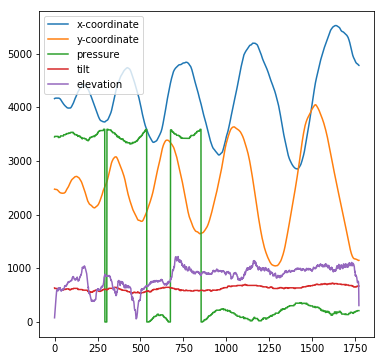

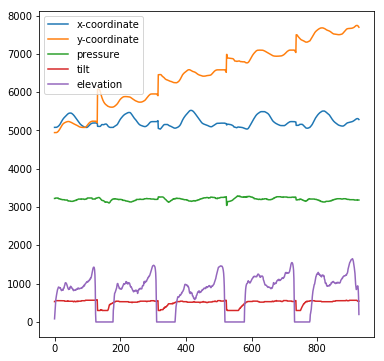

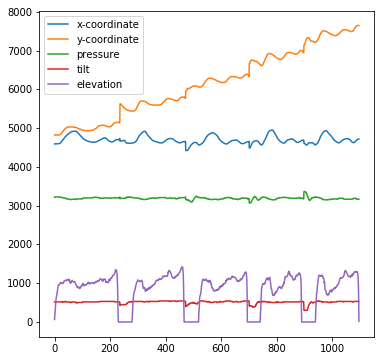

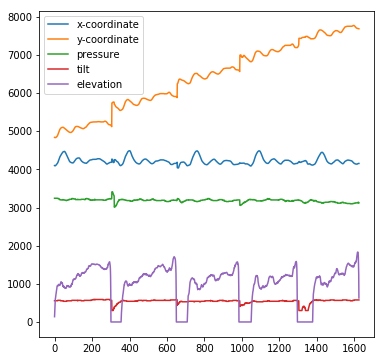

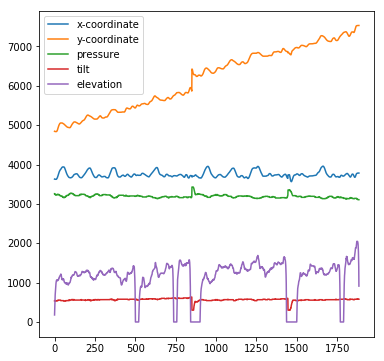

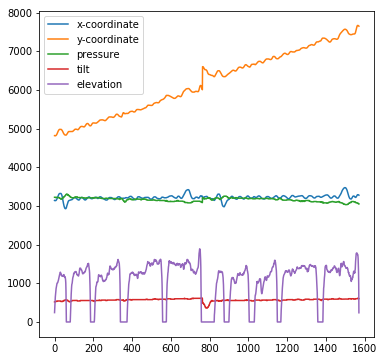

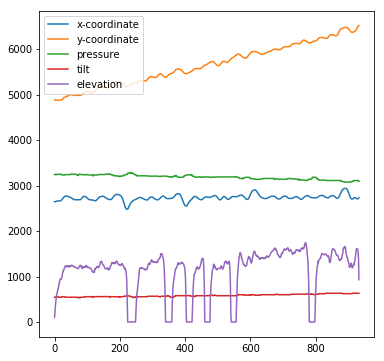

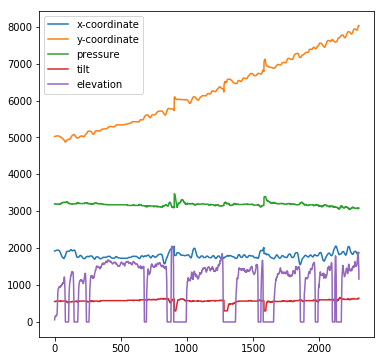

In [16]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
for j in range(8):
    print(index2task[j])
    task=np.asarray(raw[subject_index][j],dtype=int)
    if task.size!=0:
        plt.figure(figsize=(6,6))
        for i in [0,1,4,5,6]:
            plt.plot(task[:,i],label=index2measure[i])
            plt.legend()
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))
    

13
spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


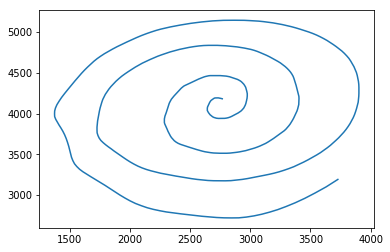

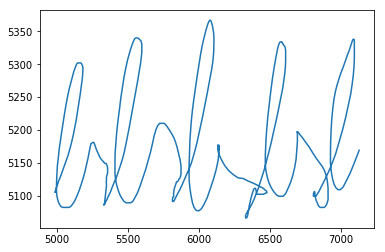

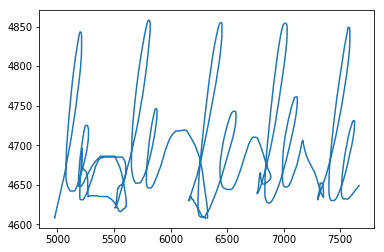

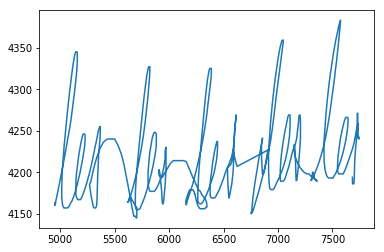

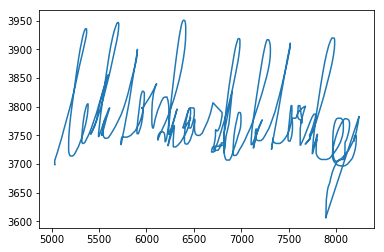

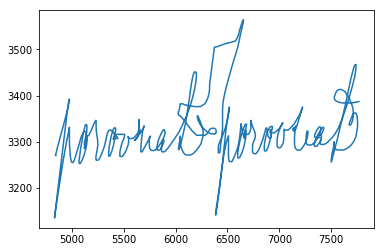

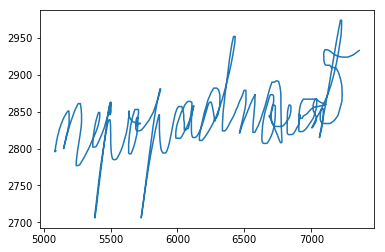

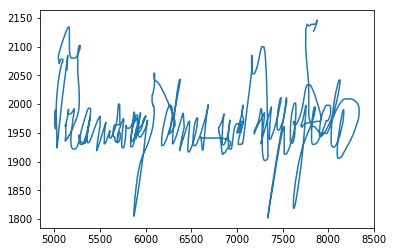

In [437]:
%matplotlib inline
subject_index=13#np.random.randint(0,len(labels))
print(subject_index)
for j in range(8):
    print(index2task[j])
    task=np.asarray(raw[subject_index][j],dtype=int)
    if task.size!=0:
        plt.figure()
        plt.plot(task[:,1],task[:,0])
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))

## Preprocessing


### Standardize
I think it distorts a little bit the data, unlike normalizing

0
spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/

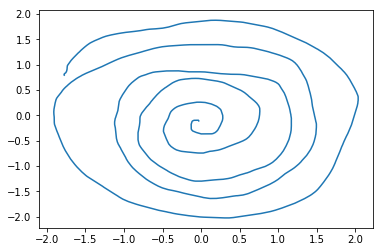

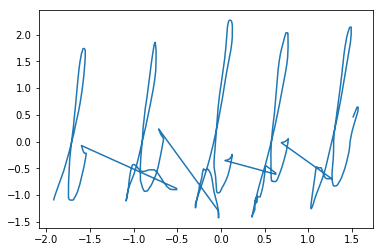

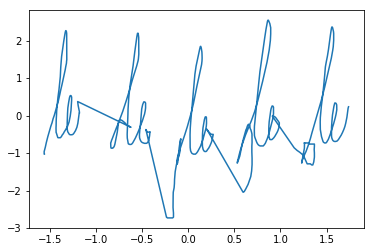

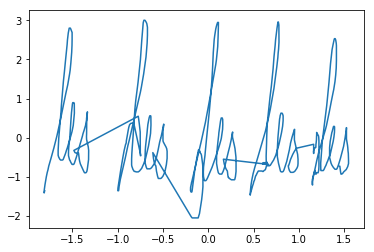

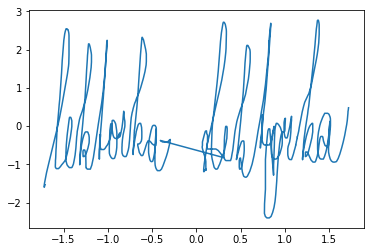

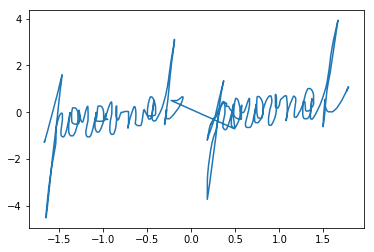

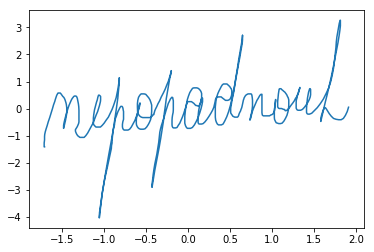

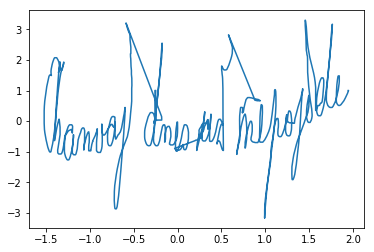

In [502]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
print(subject_index)
for j in range(8):
    print(index2task[j])
    task=scale(np.asarray(raw[subject_index][j],dtype=int),axis=0)
    if task.size!=0:
        plt.figure()
        plt.plot(task[:,1],task[:,0])
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))

### Normalization
Normalize along axis 0 in order to normalize all the measures (and not all tasks independently)

spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


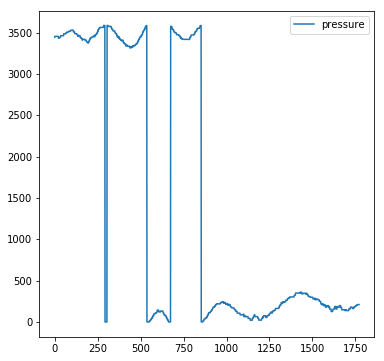

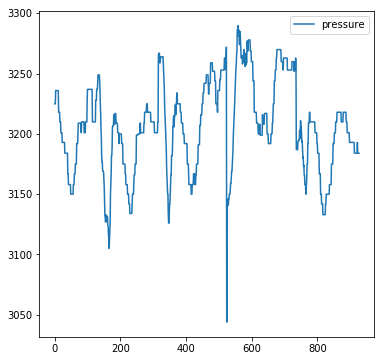

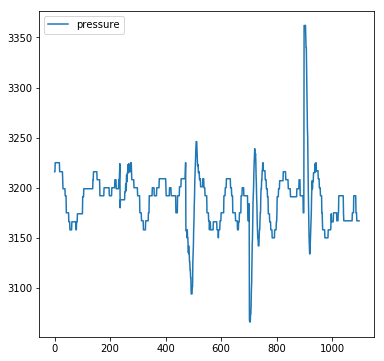

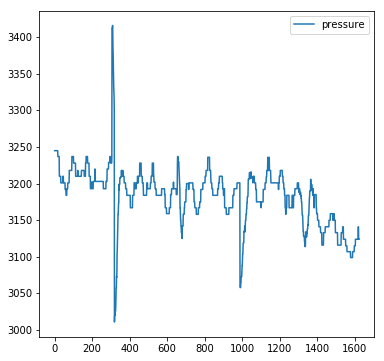

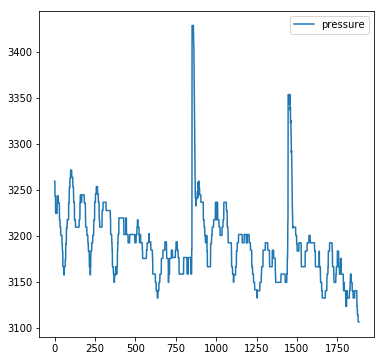

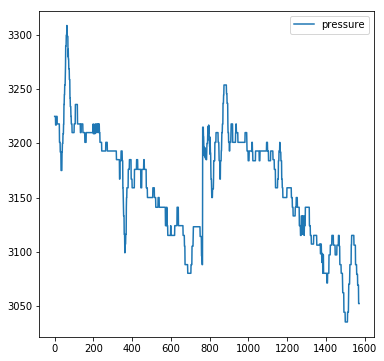

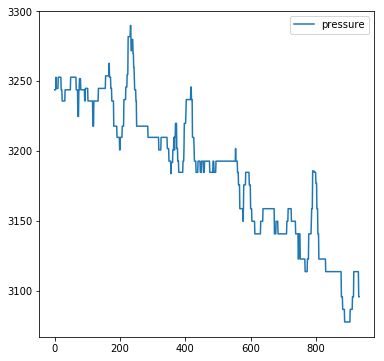

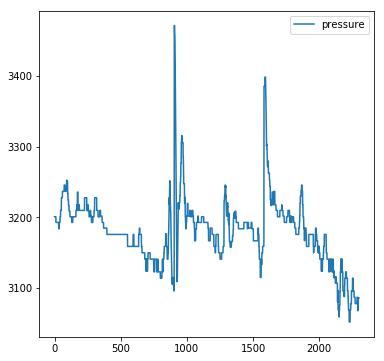

In [21]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
for j in range(8):
    print(index2task[j])
    task=np.asarray(raw[subject_index][j],dtype=int)
    if task.size!=0:
        plt.figure(figsize=(6,6))
        for i in [4]:
            plt.plot(task[:,i],label=index2measure[i])
            plt.legend()
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))
    

spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


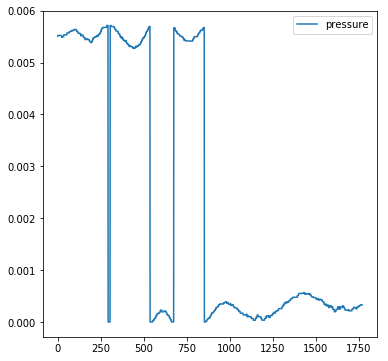

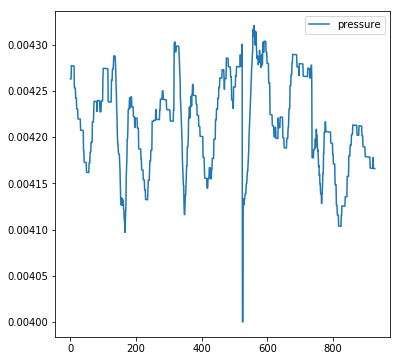

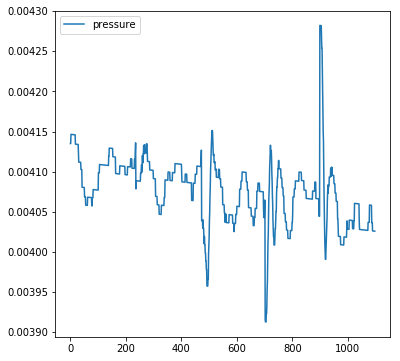

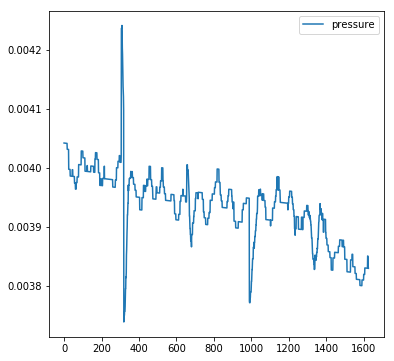

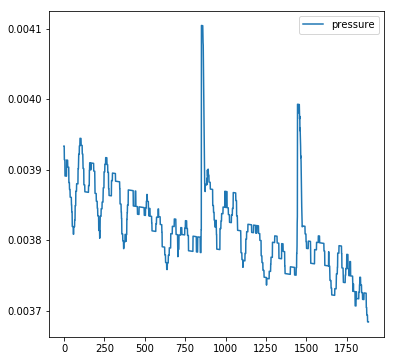

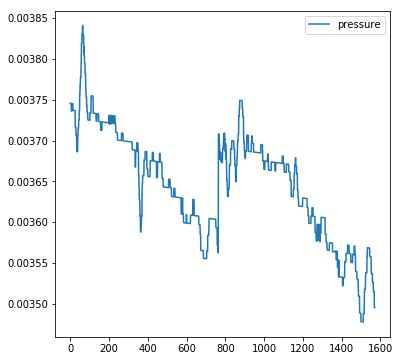

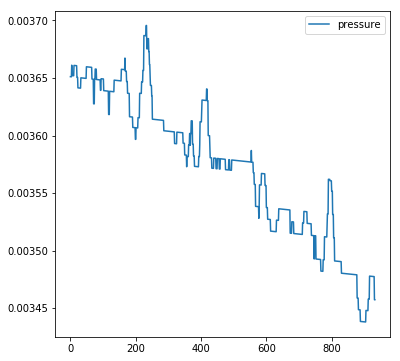

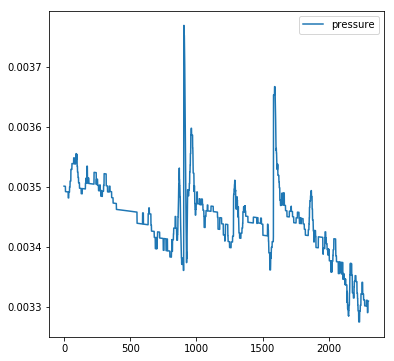

In [25]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
for j in range(8):
    print(index2task[j])
    task=normalize(np.asarray(raw[subject_index][j],dtype=int))
    if task.size!=0:
        plt.figure(figsize=(6,6))
        for i in [4]:
            plt.plot(task[:,i],label=index2measure[i])
            plt.legend()
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))
    

0
spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


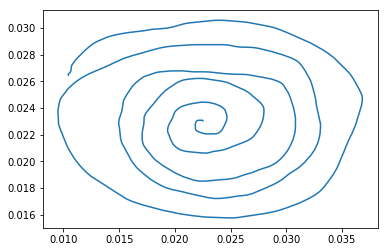

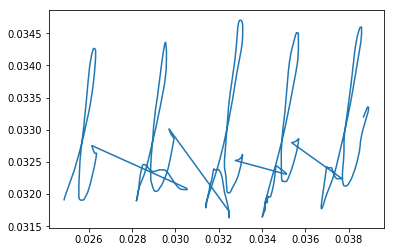

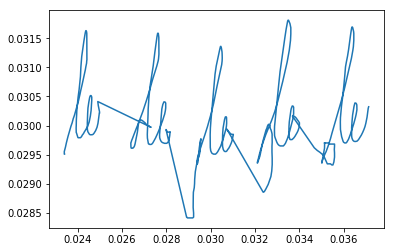

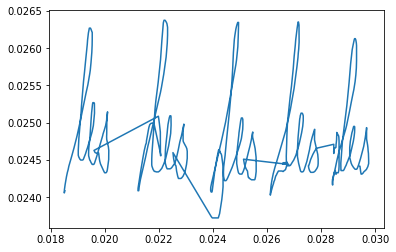

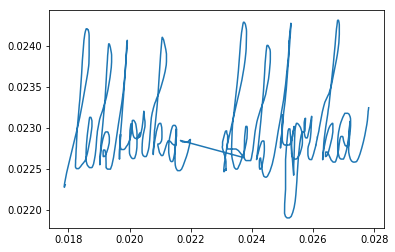

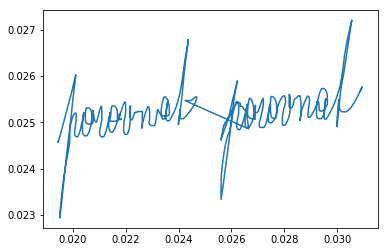

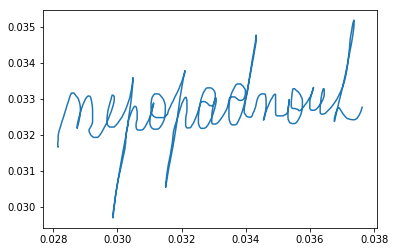

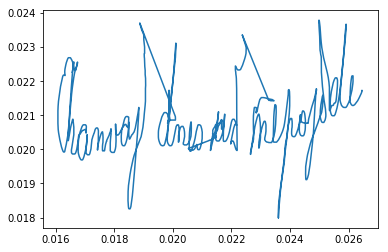

In [41]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
print(subject_index)
for j in range(8):
    print(index2task[j])
    task=normalize(np.asarray(raw[subject_index][j],dtype=int),axis=0)
    if task.size!=0:
        plt.figure()
        plt.plot(task[:,1],task[:,0])
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))

## Spirals

In [12]:
spirals=[raw[i][0]  for i,subject in enumerate(raw) if len(raw[i][0])!=0]#discard the subjects that didn't perform spiral

In [13]:
spiral_targets= [labels[i]  for i,subject in enumerate(raw) if len(raw[i][0])!=0]
#for multi class #
#spiral_targets=[target[i]  for i,subject in enumerate(raw) if len(raw[i][0])!=0]
#discard the subjects that didn't perform spiral

In [14]:
spiral_lengths=[len(spiral) for spiral in spirals]

the lengths of the spirals is extremely variable :  
mean, std :  
(2873.6944444444443, 2242.0327745578024)

But the length of the spiral is not discriminant

In [15]:
np.mean(spiral_lengths),np.std(spiral_lengths)

(2873.6944444444443, 2242.0327745578024)

In [16]:
for i,spiral in enumerate(spirals):
    spirals[i]=scale(np.asarray(spiral,dtype=int),axis=0)

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/

In [17]:
len(spirals),len(spiral_targets)

(72, 72)

In [107]:
#spiral_targets=np.asarray(spiral_targets,dtype=int)

### Data split
In order to provide for a meaningful comparison with works from Drotar et al. and Moetesum et al. we will evaluate our results using a 10-fold cross validation

In [88]:
"""split_ratio=len(spiral_targets)-len(spiral_targets)//10,len(spiral_targets)//10

split_ratio

split_ratio[0]+split_ratio[1]==len(spiral_targets)

np.random.seed(1)
random_index=np.random.randint(0,high=len(spiral_targets),size=(len(spiral_targets)))

random_index

train_set=[spirals[i] for i in random_index[0:split_ratio[0]]]
test_set=[spirals[i] for i in random_index[split_ratio[0]:split_ratio[0]+split_ratio[1]]]

train_targets=[spiral_targets[i] for i in random_index[0:split_ratio[0]+1]]
test_targets=[spiral_targets[i] for i in random_index[split_ratio[0]:split_ratio[0]+split_ratio[1]+1]]

sum([1 if i[1]==1 else 0 for i in spiral_targets])

sum([1 if i[1]==1 else 0 for i in train_targets]),sum([1 if i[1]==1 else 0 for i in test_targets])

25/65,4/7

len(train_targets),len(test_targets)"""

'split_ratio=len(spiral_targets)-len(spiral_targets)//10,len(spiral_targets)//10\n\nsplit_ratio\n\nsplit_ratio[0]+split_ratio[1]==len(spiral_targets)\n\nnp.random.seed(1)\nrandom_index=np.random.randint(0,high=len(spiral_targets),size=(len(spiral_targets)))\n\nrandom_index\n\ntrain_set=[spirals[i] for i in random_index[0:split_ratio[0]]]\ntest_set=[spirals[i] for i in random_index[split_ratio[0]:split_ratio[0]+split_ratio[1]]]\n\ntrain_targets=[spiral_targets[i] for i in random_index[0:split_ratio[0]+1]]\ntest_targets=[spiral_targets[i] for i in random_index[split_ratio[0]:split_ratio[0]+split_ratio[1]+1]]\n\nsum([1 if i[1]==1 else 0 for i in spiral_targets])\n\nsum([1 if i[1]==1 else 0 for i in train_targets]),sum([1 if i[1]==1 else 0 for i in test_targets])\n\n25/65,4/7\n\nlen(train_targets),len(test_targets)'

In [ ]:
"""first_train_index=0
first_test_index=split_ratio[1]

spiral_targets(random_index[first_train_index]:random_index[first_test_index])"""

# Model
- [**Pytorch LSTM doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM)
- [**Pytorch Linear doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)

## Definition

In [18]:
class Model(torch.nn.Module):
    """
    Args:
        #Vanilla LSTM
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two LSTMs together to form a `stacked LSTM`,
            with the second LSTM taking in outputs of the first LSTM and
            computing the final results. Default: 1
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False``
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            LSTM layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional LSTM. Default: ``False``
        
        #our model
        batch_size : default : 1
        output_size : default : 2
    """
    def __init__(self, input_size, hidden_size,num_layers=1, bias=True,batch_first=False,
                 dropout=0,bidirectional=False, batch_size=1, output_size=2):
        super(Model, self).__init__()
        #Vanilla LSTM
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias=bias
        self.batch_first=batch_first
        self.dropout=dropout
        self.bidirectional=bidirectional
        #our model
        self.batch_size = batch_size
        self.output_size = output_size

        # Define the LSTM layer
        self.encoder = torch.nn.LSTM(self.input_size, self.hidden_size, self.num_layers,self.bias,self.batch_first,
                            self.dropout,self.bidirectional)

        # Define the decoder layer
        self.linear = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def init_hidden(self):
        """h_0 of shape (num_layers * num_directions, batch, hidden_size): 
        tensor containing the initial hidden state for each element in the batch. 
        If the RNN is bidirectional, num_directions should be 2, else it should be 1.

        c_0 of shape (num_layers * num_directions, batch, hidden_size): 
        tensor containing the initial cell state for each element in the batch.
        """
        num_directions=1
        if self.bidirectional:
            num_directions=2
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers*num_directions, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers*num_directions, self.batch_size, self.hidden_size))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of encoder_out: (seq_len, batch, num_directions * hidden_size)
        # shape of self.hidden: (h_n, c_n), where hidden state h_n and cell state c_n both 
        # have shape (num_layers * num_directions, batch, hidden_size).
        encoder_out, self.hidden = self.encoder(input)
        #print(encoder_out.shape)
        
        if self.bidirectional:
            #sums the outputs : direction left-right and direction right-left
            # encoder_out shape should now be (seq_len, batch,hidden_size)
            encoder_out = encoder_out[: ,: ,: self.hidden_size] + encoder_out[: , :, self.hidden_size: ]
        
        # Only take the output from the final timestep
        # Can pass on the entirety of encoder_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(encoder_out[-1])
        y_pred = self.sigmoid(y_pred)
        return y_pred.squeeze(0)


## Hyperparameters / Init

In [24]:
input_size=7#==len(index2measure)
hidden_size=100
num_layers=2
bias=True
batch_first=False#we should unsqueeze(1) to add a batch dimension
dropout=0.0
bidirectional=True
batch_size=1
output_size=1#binary classif : 1 means PD, 0 means control
learning_rate = 1e-3



In [25]:
model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                 dropout,bidirectional, batch_size, output_size)
model.hidden=model.init_hidden()
model=model.to(device)
loss_fn=torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training
## step
[**Pytorch Binary Cross Entropy loss (BCELoss) doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)

In [21]:
def step(input, target, model, optimizer, loss_fn, batch_size,validation = False):
    if not validation:
        # Zero gradients
        optimizer.zero_grad()    
        
    # Set device options
    input=input.to(device)
    target=target.to(device)
        
    #forward pass
    output=model(input)
    
    # Compute loss
    loss = loss_fn(output, target)
    
    
    
    if not validation:
        # Perform backpropagation
        loss.backward()
        #clip gradients to previent exploding
        torch.nn.utils.clip_grad_norm_(model.parameters(), 50.0)
        # Adjust model weights
        optimizer.step()
    
    return loss.item(), output.item()

## epoch

In [22]:
def epoch(data,targets, model, optimizer, loss_fn, batch_size, random_index,validation=False):
    losses=[]
    predictions=[]
    condition_targets=[]
    
    for index in random_index:
        condition_targets.append(targets[index])
        #numpy to tensor
        subject=torch.Tensor(data[index]).unsqueeze(1)#add batch dimension
        target=torch.Tensor([targets[index]])        
        loss, prediction =step(subject,target, model, optimizer, loss_fn, batch_size,validation)
        predictions.append(round(prediction))
        losses.append(loss)
    
    #compute metrics
    tn, fp, fn, tp = metrics.confusion_matrix(y_true=condition_targets,y_pred=predictions,labels=[0,1]).ravel()
    condition_positive=tp+fn
    condition_negative=tn+fp
    accuracy= (tp+tn)/(tp+tn+fp+fn)
    sensitivity = tp/condition_positive if condition_positive != 0 else 0.0 #without condition positives the sensitivity should be 0
    specificity = tn/condition_negative if condition_negative!= 0 else 0.0 #idem
    
    return [np.mean(losses),accuracy,sensitivity,specificity]

In [26]:
save_metrics=[]
start = time()
model.train()
np.random.seed(1)
for i in range(15):
    random_index=np.random.randint(0,high=len(spiral_targets),size=(len(spiral_targets)))
    loss,accuracy,sensitivity,specificity=epoch(spirals,spiral_targets, model, optimizer, loss_fn, batch_size, random_index)
    save_metrics.append([loss,accuracy,sensitivity,specificity])
    print("epoch n°{}, spent {}, loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f} ".format(
        i,timeSince(start),loss,accuracy,sensitivity,specificity))


epoch n°0, spent 0m 45s, loss 0.693, accuracy 0.556, sensitivity  0.921, specificity 0.147 
epoch n°1, spent 1m 28s, loss 0.690, accuracy 0.556, sensitivity  0.732, specificity 0.323 
epoch n°2, spent 2m 11s, loss 0.659, accuracy 0.625, sensitivity  0.429, specificity 0.750 
epoch n°3, spent 2m 56s, loss 0.664, accuracy 0.597, sensitivity  0.351, specificity 0.857 
epoch n°4, spent 3m 47s, loss 0.597, accuracy 0.653, sensitivity  0.692, specificity 0.606 
epoch n°5, spent 4m 37s, loss 0.652, accuracy 0.597, sensitivity  0.595, specificity 0.600 
epoch n°6, spent 5m 20s, loss 0.574, accuracy 0.681, sensitivity  0.576, specificity 0.769 
epoch n°7, spent 6m 7s, loss 0.588, accuracy 0.694, sensitivity  0.588, specificity 0.789 
epoch n°8, spent 6m 50s, loss 0.590, accuracy 0.694, sensitivity  0.594, specificity 0.775 
epoch n°9, spent 7m 36s, loss 0.521, accuracy 0.736, sensitivity  0.811, specificity 0.657 
epoch n°10, spent 8m 25s, loss 0.612, accuracy 0.681, sensitivity  0.737, specifi

In [27]:
for i in range(15,30):
    random_index=np.random.randint(0,high=len(spiral_targets),size=(len(spiral_targets)))
    loss,accuracy,sensitivity,specificity=epoch(spirals,spiral_targets, model, optimizer, loss_fn, batch_size, random_index)
    save_metrics.append([loss,accuracy,sensitivity,specificity])
    print("epoch n°{}, spent {}, loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f} ".format(
        i,timeSince(start),loss,accuracy,sensitivity,specificity))

epoch n°15, spent 12m 31s, loss 0.568, accuracy 0.681, sensitivity  0.700, specificity 0.656 
epoch n°16, spent 13m 18s, loss 0.568, accuracy 0.722, sensitivity  0.706, specificity 0.737 
epoch n°17, spent 14m 3s, loss 0.561, accuracy 0.736, sensitivity  0.750, specificity 0.725 
epoch n°18, spent 14m 48s, loss 0.541, accuracy 0.667, sensitivity  0.639, specificity 0.694 
epoch n°19, spent 15m 36s, loss 0.414, accuracy 0.833, sensitivity  0.733, specificity 0.905 
epoch n°20, spent 16m 27s, loss 0.373, accuracy 0.833, sensitivity  0.714, specificity 1.000 
epoch n°21, spent 17m 11s, loss 0.334, accuracy 0.833, sensitivity  0.704, specificity 0.911 
epoch n°22, spent 17m 52s, loss 0.479, accuracy 0.750, sensitivity  0.743, specificity 0.757 
epoch n°23, spent 18m 39s, loss 0.480, accuracy 0.764, sensitivity  0.750, specificity 0.775 
epoch n°24, spent 19m 23s, loss 0.355, accuracy 0.861, sensitivity  0.829, specificity 0.892 
epoch n°25, spent 20m 12s, loss 0.371, accuracy 0.819, sensit

In [511]:
subject=torch.Tensor(spirals[61]).unsqueeze(1)#add batch dimension
target=torch.Tensor([spiral_targets[61]])
subject.shape,target.shape

(torch.Size([858, 1, 7]), torch.Size([1]))

In [514]:
step(subject,target, model, optimizer, loss_fn, batch_size)

(0.03701569139957428, 0.036338984966278076)

# Visualization

## Training

### Loss

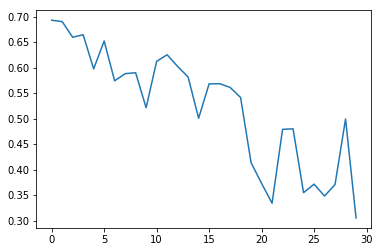

In [28]:
plt.plot(np.asarray(save_metrics)[:,0])

### Accuracy

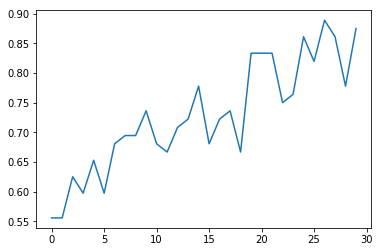

In [34]:
plt.plot(np.asarray(save_metrics)[:,1])

# Evaluation

In [150]:
model.eval()
eval_metrics=epoch(spirals,spiral_targets, model, optimizer, loss_fn, batch_size, random_index,validation=True)